In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save simulation results
import dill
import pickle

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# AR1 model using python
#from models.AR1 import ar1_predict, ar1_f, ar1_jac

# data assimilation routines
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import _EKF, _EKS, EKS, EM_EKS
from algos.LI_EKS import LI_EKF, LI_EKS
from algos.CI_EKS import CI_EKF, CI_EKS
from algos.BI_EKF import BI_EKF
from algos.utils import climat_background, RMSE, gen_truth, gen_obs, cov_prob

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


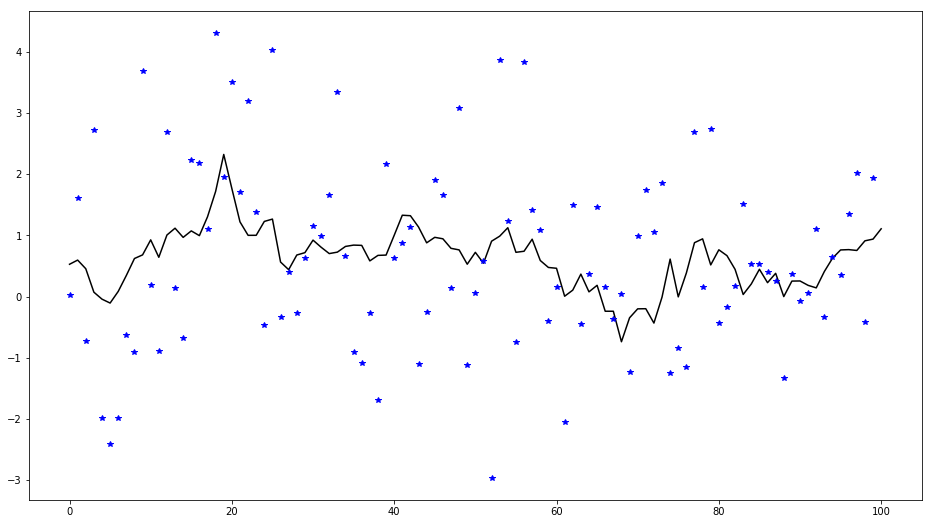

In [3]:
# random number generator
prng = numpy.random.RandomState(1)

# dynamical model
Nx = 1
f = lambda x: 0.95*x
jacF = lambda x: array([0.95])

# observation operator
No = 1
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = eye(Nx)

# size of the sequence
T = 100

# generate state
Q_true = eye(Nx) * .1
X0_true = array(zeros(Nx))
X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1
R_true = eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

# plot state and observations
plot(X_true[:,:1000].T,'k-')
plot(Yo[:,:1000].T, '*b')

In [48]:
# background state
xb, B_tmp = climat_background(X_true)
B = eye(Nx)*B_tmp

# parameters
params = { 'observations'                 : Yo,
           'background_state'             : xb,
           'background_covariance'        : B,
           'model_noise_covariance'       : Q_true,
           'observation_noise_covariance' : R_true,
           'model_dynamics'               : f,
           'model_jacobian'               : jacF,
           'observation_operator'         : h,
           'observation_jacobian'         : jacH,
           'state_size'                   : Nx,
           'observation_size'             : No,
           'temporal_window_size'         : T,
           'true_state'                   : X_true,
           'inflation_factor'             : 1
          }

# function
res_EKS = EKS(params)

# extract outputs
loglik_true = res_EKS['loglikelihood']
RMSE_true = res_EKS['RMSE']
cov_prob_true = res_EKS['cov_prob']

In [30]:
# number of experiments and iterations
N = 100 
N_iter = 100

# initializations
tab_Q_EM        = zeros((N, N_iter))
tab_R_EM        = zeros((N, N_iter))
tab_loglik_EM   = zeros((N, N_iter))
tab_RMSE_EM     = zeros((N, N_iter))
tab_cov_prob_EM = zeros((N, N_iter))
tab_Q_LI        = zeros((N, N_iter))
tab_R_LI        = zeros((N, N_iter))
tab_loglik_LI   = zeros((N, N_iter))
tab_RMSE_LI     = zeros((N, N_iter))
tab_cov_prob_LI = zeros((N, N_iter))

# loop
for i in range(N): 
    
    # initial counditions
    Q_init = eye(Nx)*random.uniform(0.1,10,1) # random uniform [0.1,10] value for initial Q
    R_init = eye(No)*random.uniform(0.1,10,1) # random uniform [0.1,10] value for initial R
    
    #################### EM ####################
    # parameters
    params = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : f,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Yo,
               'nb_EM_iterations'                         : N_iter,
               'true_state'                               : X_true,
               'state_size'                               : Nx,
               'observation_size'                         : No,
               'temporal_window_size'                     : T,
               'model_noise_covariance_structure'         : 'full', # Q and R are full
               #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : True, ### IMPORTANT
               'inflation_factor'                         : 1}

    # function
    res_EM_EKS = EM_EKS(params)
    
    # outputs
    tab_Q_EM[i,:]        = res_EM_EKS['EM_model_noise_covariance'][0,0,1:]
    tab_R_EM[i,:]        = res_EM_EKS['EM_observation_noise_covariance'][0,0,1:]
    tab_loglik_EM[i,:]   = res_EM_EKS['loglikelihood'][:]
    tab_RMSE_EM[i,:]     = res_EM_EKS['RMSE'][:]
    tab_cov_prob_EM[i,:] = res_EM_EKS['cov_prob'][:]
    #################### EM ####################
    
    #################### LI ####################
    # parameters
    params = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : f,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Yo,
               'nb_iterations'                            : N_iter,
               'true_state'                               : X_true,
               'state_size'                               : Nx,
               'observation_size'                         : No,
               'temporal_window_size'                     : T,
               'model_noise_covariance_structure'         : 'full', # Q and R are full
               'inflation_factor'                         : 1,
               'adaptive_parameter'                       : 1000
    }

    # function
    res_LI_EKS = LI_EKS(params)
    
    # outputs
    tab_Q_LI[i,:]        = res_LI_EKS['LI_model_noise_covariance'][0,0,1:]
    tab_R_LI[i,:]        = res_LI_EKS['LI_observation_noise_covariance'][0,0,1:]
    tab_loglik_LI[i,:]   = res_LI_EKS['loglikelihood'][:]
    tab_RMSE_LI[i,:]     = res_LI_EKS['RMSE'][:]
    tab_cov_prob_LI[i,:] = res_LI_EKS['cov_prob'][:]
    #################### LI ####################
    
# stock results
res_EM_LI_EKS_AR1_initial_conditions = {
    'tab_Q_EM'        : tab_Q_EM,
    'tab_R_EM'        : tab_R_EM,
    'tab_loglik_EM'   : tab_loglik_EM, 
    'tab_RMSE_EM'     : tab_RMSE_EM,
    'tab_cov_prob_EM' : tab_cov_prob_EM,
    'tab_Q_LI'        : tab_Q_LI,
    'tab_R_LI'        : tab_R_LI,
    'tab_loglik_LI'   : tab_loglik_LI, 
    'tab_RMSE_LI'     : tab_RMSE_LI,
    'tab_cov_prob_LI' : tab_cov_prob_LI
}

# store simulation results
#dill.dump(res_EM_LI_EKS_AR1_initial_conditions, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_initial_conditions.pkl', 'wb'))

  4%|▍         | 4/100 [00:00<00:02, 39.24it/s]/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in sqrt
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:])) / T
/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in less_equal
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:])) / T
/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in greater_equal
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:])) 

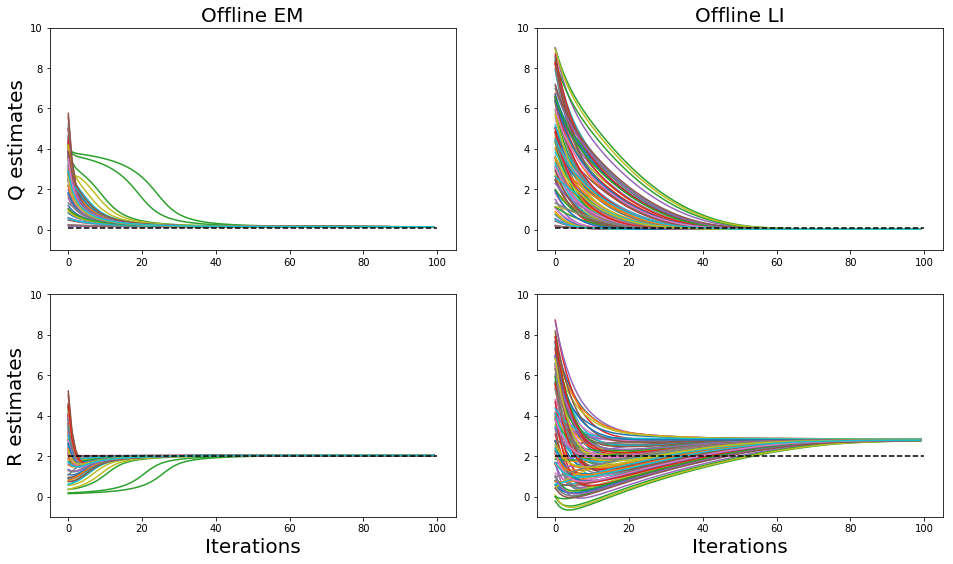

In [33]:
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_initial_conditions.pkl', 'rb') as in_strm:
    res_EM_LI_EKS_AR1_initial_conditions = dill.load(in_strm)

# plot simulations
subplot(2,2,1)
plot(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'].T)
plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
#xlabel('Iterations', fontsize=20)
ylabel('Q estimates', fontsize=20)
title('Offline EM', fontsize=20)
ylim([-1,10])
subplot(2,2,2)
plot(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'].T)
plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
#xlabel('Iterations', fontsize=20)
#ylabel('Q estimates', fontsize=20)
title('Offline LI', fontsize=20)
ylim([-1,10])
subplot(2,2,3)
plot(res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'].T)
plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Iterations', fontsize=20)
ylabel('R estimates', fontsize=20)
#title('Offline EM', fontsize=20)
ylim([-1,10])
subplot(2,2,4)
plot(res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'].T)
plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Iterations', fontsize=20)
#ylabel('R estimates', fontsize=20)
#title('Offline LI', fontsize=20)
ylim([-1,10])

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/comparison_EM_LI_AR1_initial_conditions.png', bbox_inches='tight')

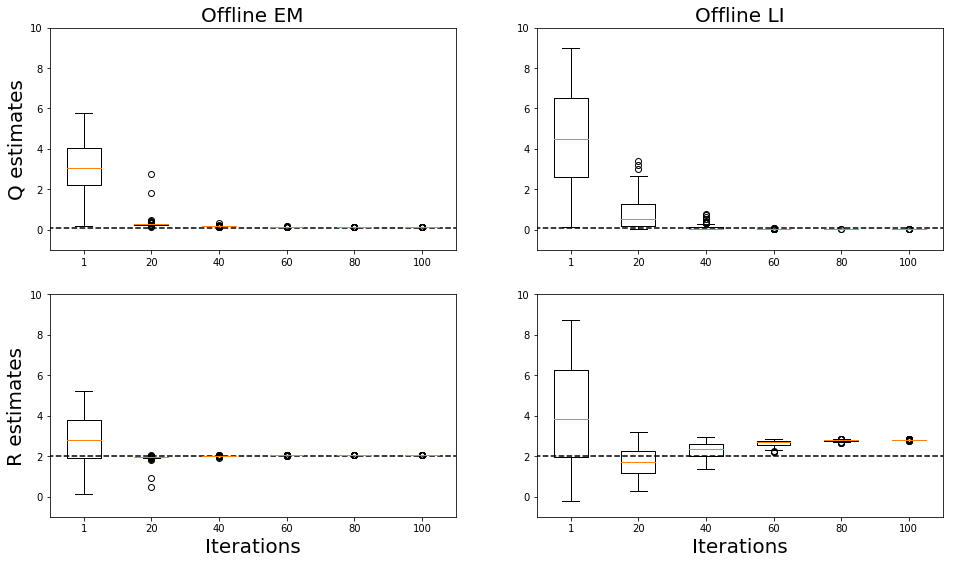

In [41]:
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_initial_conditions.pkl', 'rb') as in_strm:
    res_EM_LI_EKS_AR1_initial_conditions = dill.load(in_strm)

# plot boxplots
subplot(2,2,1)
boxplot([res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,0], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,19],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,39], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,59],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,79], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'][:,99]])
xticks([1, 2, 3, 4, 5, 6], ['1', '20', '40', '60', '80', '100'])
plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
#xlabel('Iterations', fontsize=20)
ylabel('Q estimates', fontsize=20)
title('Offline EM', fontsize=20)
ylim([-1,10])
subplot(2,2,2)
boxplot([res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,0], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,19],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,39], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,59],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,79], res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'][:,99]])
xticks([1, 2, 3, 4, 5, 6], ['1', '20', '40', '60', '80', '100'])
plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
#xlabel('Iterations', fontsize=20)
#ylabel('Q estimates', fontsize=20)
title('Offline LI', fontsize=20)
ylim([-1,10])
subplot(2,2,3)
boxplot([res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,0], res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,19],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,39], res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,59],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,79], res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'][:,99]])
xticks([1, 2, 3, 4, 5, 6], ['1', '20', '40', '60', '80', '100'])
plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Iterations', fontsize=20)
ylabel('R estimates', fontsize=20)
#title('Offline EM', fontsize=20)
ylim([-1,10])
subplot(2,2,4)
boxplot([res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,0], res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,19],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,39], res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,59],\
        res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,79], res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'][:,99]])

xticks([1, 2, 3, 4, 5, 6], ['1', '20', '40', '60', '80', '100'])
plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Iterations', fontsize=20)
#ylabel('R estimates', fontsize=20)
#title('Offline LI', fontsize=20)
ylim([-1,10])

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/comparison_EM_LI_AR1_initial_conditions_boxplot.png', bbox_inches='tight')

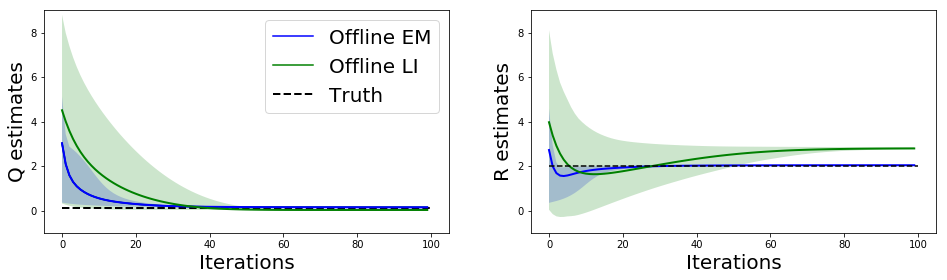

In [5]:
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_initial_conditions.pkl', 'rb') as in_strm:
    res_EM_LI_EKS_AR1_initial_conditions = dill.load(in_strm)

N_iter = 100    
    
def plot_CI_plot(x_axis, mean_ci, lower_ci, upper_ci, color, alpha_val):
    plot(x_axis, mean_ci, color, linewidth=2)
    fill_between(x_axis, lower_ci, upper_ci, facecolor=color, alpha=alpha_val)

# plot confidence intervals
alpha = 0.2
subplot(2,2,1)
line1, = plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'], 0), 'blue')
line2, = plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'], 0), 'green')
line3, = plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k', linewidth=2)
plot_CI_plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'], 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_EM'], 97.5, 0), 'blue', alpha)
plot_CI_plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'], 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_Q_LI'], 97.5, 0), 'green', alpha)
legend([line1, line2, line3], ['Offline EM', 'Offline LI', 'Truth'], fontsize=20)
xlabel('Iterations', fontsize=20)
ylabel('Q estimates', fontsize=20)
ylim([-1,9])
subplot(2,2,2)
plot_CI_plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'], 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_R_EM'], 97.5, 0), 'blue', alpha)
plot_CI_plot(range(N_iter), mean(res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'], 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_initial_conditions['tab_R_LI'], 97.5, 0), 'green', alpha)
plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Iterations', fontsize=20)
ylabel('R estimates', fontsize=20)
ylim([-1,9])

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/comparison_EM_LI_AR1_initial_conditions_CI.png', bbox_inches='tight')